/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
20/20 - 23s - 1s/step - accuracy: 0.2164 - loss: 1.6068 - val_accuracy: 0.1887 - val_loss: 1.6007
Epoch 2/20
20/20 - 40s - 2s/step - accuracy: 0.3665 - loss: 1.5186 - val_accuracy: 0.5660 - val_loss: 1.3686
Epoch 3/20
20/20 - 20s - 979ms/step - accuracy: 0.6398 - loss: 1.0387 - val_accuracy: 0.7987 - val_loss: 0.6861
Epoch 4/20
20/20 - 19s - 952ms/step - accuracy: 0.7930 - loss: 0.5784 - val_accuracy: 0.8302 - val_loss: 0.5573
Epoch 5/20
20/20 - 18s - 911ms/step - accuracy: 0.8689 - loss: 0.4015 - val_accuracy: 0.8365 - val_loss: 0.5288
Epoch 6/20
20/20 - 21s - 1s/step - accuracy: 0.8989 - loss: 0.2702 - val_accuracy: 0.8365 - val_loss: 0.6138
Epoch 7/20
20/20 - 18s - 904ms/step - accuracy: 0.9305 - loss: 0.2100 - val_accuracy: 0.8616 - val_loss: 0.6293
Epoch 8/20
20/20 - 20s - 1s/step - accuracy: 0.9542 - loss: 0.1571 - val_accuracy: 0.8616 - val_loss: 0.6332
7/7 - 1s - 146ms/step - accuracy: 0.8535 - loss: 0.5002
Test Accuracy: 0.8535
Test Loss: 0.5002
7/7 ━━━━━━━━━━━━━━━━

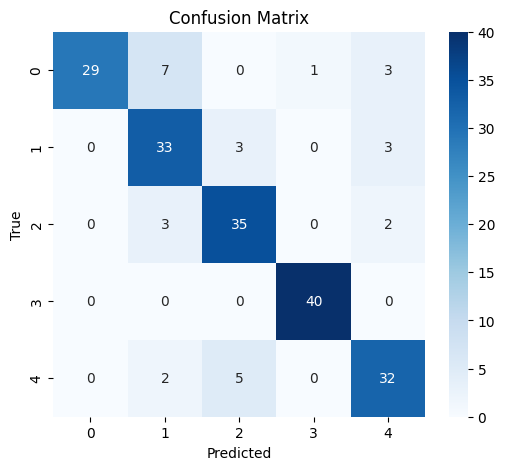

Macro F1 Score: 0.8535


<ipython-input-1-a589f6aa6147>:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="viridis")


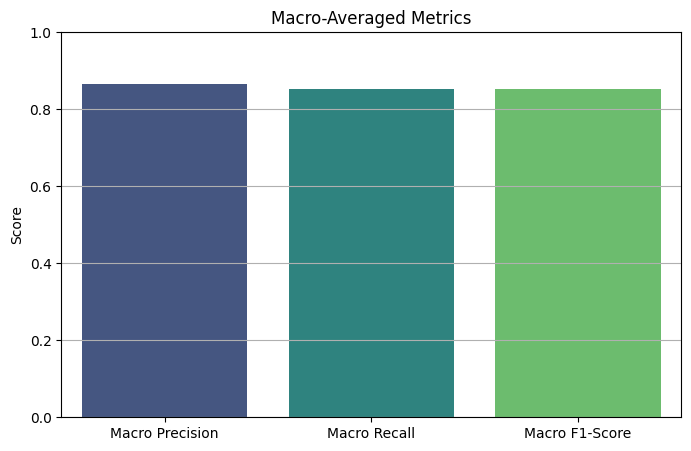

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Predictions saved to: /content/drive/MyDrive/base_cnn_tfidf_predictions.csv


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Load dataset
dataset_path = '/content/drive/MyDrive/processed_train_data_telugu1.csv'
df = pd.read_csv(dataset_path)

X = df['Text']
y = pd.get_dummies(df['Label']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['Label'])

# Text Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))  # Using TF-IDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

# CNN Model
def create_cnn_model(input_dim, dropout_rate):
    model = Sequential([
        # No embedding, directly use the count vector
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=(input_dim, 1)),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),

        # Additional convolutional layer (optional)
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),

        # Flatten the output
        Flatten(),

        # Fully connected layers
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),

        # Output layer for multi-class classification
        Dense(y.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


dropout_rate = 0.5
batch_size = 32
epochs = 20
input_dim = X_train_tfidf.shape[1]  # Number of features from TF-IDF

# Create CNN model
model = create_cnn_model(input_dim, dropout_rate)

# Train the model
history = model.fit(
    X_train_tfidf, y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose=2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_tfidf, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)
y_pred_labels = y_pred.argmax(axis=1)
y_true_labels = y_test.argmax(axis=1)

print("CNN Model Classification Report:\n", classification_report(y_true_labels, y_pred_labels))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Calculate Macro Precision, Recall, and F1 Score
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
    y_true_labels, y_pred_labels, average="macro"
)

# Print Macro F1 Score
print(f"Macro F1 Score: {macro_f1:.4f}")

metrics = ["Macro Precision", "Macro Recall", "Macro F1-Score"]
values = [macro_precision, macro_recall, macro_f1]

plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.title("Macro-Averaged Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.show()

# Process new test data
test_dataset_path = '/content/drive/MyDrive/processed_test_data_telug.csv'
test_df = pd.read_csv(test_dataset_path)

X_test_new = test_df['Transcript']

# Transform new test data using the same TF-IDF Vectorizer
X_test_new_tfidf = tfidf_vectorizer.transform(X_test_new).toarray()

# Predict using the CNN model
y_pred_new = model.predict(X_test_new_tfidf)
y_pred_labels_new = y_pred_new.argmax(axis=1)

# Map the predicted labels to original label names
label_columns = pd.get_dummies(df['Label']).columns
predicted_labels = label_columns[y_pred_labels_new]

# Add predictions to the test dataframe
test_df['CNN'] = predicted_labels

# Save the predictions to a CSV file
output_path = '/content/drive/MyDrive/base_cnn_tfidf_predictions.csv'
test_df[['Transcript', 'CNN']].to_csv(output_path, index=False)

print(f"Predictions saved to: {output_path}")
